# Lab 02 - Model selection - Exploration of TREFLE

Lab developed by: Diogo  Leite - 03.2019<br>
Trefle algorithm: Gary Marigliano. (Based on the PhD thesis of Carlos Peña https://infoscience.epfl.ch/record/33110)

# Instructions
<br>
In this notebook, we use three datasets: Cancer, Breast Cancer Wisconsin (Diagnostic) BCWD, and GOLUB.

### TODO in this notebook
You should provide your answers to the questions of this notebook in a report (Note that a short and concise report with the essential information is **much** better than a long one that tells nothing...). Just indicate clearly the number of the question and give the respective answer. If you need plots to confirm your observations, include them also. At the end, send the notebook<b>-s</b> in annex to your report.
<br>
Sometimes you will need to select (decide on) some values as a way to perform filters that reduce the number of models (and save the bests).
<br>
At every question you will see which parts that question applies to: <b>0 for Cancer, 1 for BCWD, or 2 for GOLUB </b>.  You need to answer the questions according to the relevant dataset (see more instructions below).
<br>
To perform this lab you need to create three copies of the notebook (one for each dataset) and put your results in different paths and files (you will see along the lab).
<br>
<b>Some experiences take time (up to several hours), consider that in order to don't do your lab at the last minute (all the experiments are potentially different as TREFLE isn't a deterministic algorithm).
    

### How to submit your lab

Export all the notebooks in HTML format (in the case your lab could not be reproduced for any reason) + zip your whole lab folder without the datasets. If your lab requires additional dependencies, please add a INSTRUCTIONS.md file in your folder with the instructions to install them. Don't forget to add the additional dependencies at the end of your requirements.txt file (or do a pip freeze > requirements_personal.txt command).
<br>
You must write a short report (as mentioned above) with three sections (one for each dataset) and respond to all the questions in each section. Include the report (<b>PDF and only PDF</b>) on the zip. The organization of the report must follow the structure below:
<ul>
    <li>Dataset Cancer</li>
    <ul>
        <li>Question 1 </li>
        <li>Question ... </li>
    </ul>
    <li>Dataset BCWD</li>
    <ul>
        <li>Question 1 </li>
        <li>Question ... </li>
    </ul>
    <li>Dataset GOLUB</li>
    <ul>
        <li>Question 1 </li>
        <li>Question ... </li>
    </ul>
</ul>

In [ ]:
#!conda install python=3.6 --yes
#!pip install -r requirements.txt

## Set up the libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import json
import numpy as np
import random
import math



from pprint import pprint
from collections import Counter
from matplotlib.ticker import MaxNLocator
from itertools import tee



from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from trefle.fitness_functions.output_thresholder import round_to_cls
from trefle.trefle_classifier import TrefleClassifier

from trefle_engine import TrefleFIS


#Personal libraries

import libraries.measures_calculation
import libraries.trefle_project
import libraries.interpretability_methods
import libraries.interpretability_plots
import libraries.results_plot
from libraries.model_var import ModelVar
from libraries.model_train_cv import *

## Split the dataset
<br>
The first step of the ML process is to split our dataset into training and test parts (subsets). <br> 
<ul>
    <li>You need to indicate the path of your original dataset</li>
    <li>You need to indicate the path where you want to save the training part</li>
    <li>You need to indicate the path where you want to save the test part</li>
</ul>
<br>When a plot is "open" you need to "shut it down" in oder to plot the others (button on the upper corner right)

(381, 30) (381,) (188, 30) (188,)


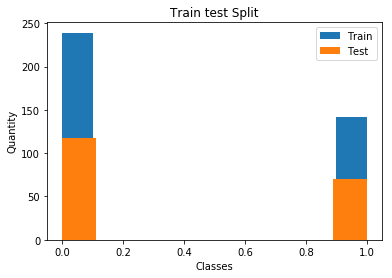

In [4]:
# 1 WDBC

from sklearn import preprocessing
#Read Dataset
#Indicate the path of the original DS HERE:
#--------------------
csv_path_file_name = './Datasets/WDBC/data_WDBC.csv'
#--------------------

data_load = pd.read_csv(csv_path_file_name, sep=",")
data_load = data_load.dropna(axis=1) # remove last colunm which only contains NaN values
data_load.head()

X = data_load.drop(['id', 'diagnosis'], axis=1).values

le = preprocessing.LabelEncoder()
le.fit(data_load["diagnosis"].values)
y = le.transform(data_load["diagnosis"].values)

#Split it into train test DS
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

plt.hist(y_train, bins='auto', label='Train')

plt.hist(y_test, bins='auto', label='Test')
plt.title("Train test Split")
plt.xlabel('Classes')
plt.ylabel('Quantity')
plt.legend()
plt.show()

#Save separetly in training and test
#It is important to save the training and test sets (we will use the test in the second part)
y_train_modify = np.reshape(y_train, (-1, 1))
train_dataset = np.append(X_train, y_train_modify, axis=1)

y_test_modify = np.reshape(y_test, (-1, 1))
test_dataset = np.append(X_test, y_test_modify, axis=1)

#This indicates to numpy how to format the output (you can create a function for a larger number of variables...)

format_values=''
for i in range(0,X_train.shape[1]):
    format_values+=" %1.3f"
format_values += " %i"

#Indicate the path where you want to save the training and test part DS HERE:
#--------------------
path_train_csv = './Datasets/WDBC/data_WDBC_train.csv'
path_test_csv = './Datasets/WDBC/data_WDBC_test.csv'
#--------------------

np.savetxt(path_train_csv, train_dataset, delimiter=",", fmt =format_values)
np.savetxt(path_test_csv, test_dataset, delimiter=",", fmt = format_values)

<b style="background-color:red;color:white">Question 1 (part 0, 1, and 2)</b>: Comment the plot above (include it into your report)

# Trefle Classifier
<br> In the code below you have a description of the (fuzzy logic-based) classifier that we use along this labo, the theory is provided in the slides of the cours. <br>
Don't forget to change, if necessary, the number of generations (iterations) of your algorithm. 

In [7]:
#Initialize our classsifier TREFLE
clf = TrefleClassifier(
    n_rules=25,
    n_classes_per_cons=[2],  # there is only 1 consequent with 2 classes
    n_labels_per_mf=3,  # use 3 labels LOW, MEDIUM, HIGH
    default_cons=[0],  # default rule yield the class 0
    n_max_vars_per_rule=5,  # WBCD dataset has 30 variables, here we force
    # to use a maximum of 3 variables per rule
    # to have a better interpretability
    # In total we can have up to 3*4=12 different variables
    # for a fuzzy system
    n_generations=100,
    verbose=False,
)

## Training and predicting with Trefle
<br> Below you have just a simple example of how to:<br>
<ul>
    <li>train a model and make a prediction with it</li>
    <li>save the model in a file</li>
</ul>

In [8]:
#Make a train
y_sklearn = np.reshape(y_train, (-1, 1))

clf.fit(X_train, y_sklearn)
# Make predictions
y_pred = clf.predict_classes(X_test)

clf.print_best_fuzzy_system()

# Evaluate accuracy
score = accuracy_score(y_test, y_pred)
print("Score on test set: {:.3f}".format(score))

tff = clf.get_best_fuzzy_system_as_tff()

# Export: save the fuzzy model to disk
with open("fuzzy_models/wdbc_trefle_fuzzy_model.tff", mode="w") as f:
    f.write(tff)

Score on test set: 0.957


# Launch the Trefle experiments (or modeling runs)
In this labo we perform a k-fold cross-validation, so you must indicate how many folds do you want (by default 10). We could perform an exhaustive parameter search, but for this labo we will only search for parameters related with the size (complexity) of the model: i.e., number of rules and variables per rule.
You must indicate where do you want to save all the models obtained. <br>

**Important:** You must choose and justify the range of values you will explore for:
<ul>
    <li>the number of rules</li>
    <li>the maximum number of variables per rule </li>
<ul>
The code must be adapted according to your choice.

### Fitness function
The fitness function (or performance function) allows you to choose which performance metrics you want to improve (maximise), in our case the sensitivity and specificity (You can see the slides for more details).
<br>
IMPORTANT: analyze the comments in the code, perform the modifications that are necessary.

In [9]:
%load_ext autoreload
%autoreload

##############fitness function (No change required)
def fit (y_true, y_pred):
    
    y_pred_bin = round_to_cls(y_pred, n_classes=2)
    tn, fp, fn, tp = libraries.trefle_project.getConfusionMatrixValues(y_true, y_pred_bin)
    
    
    sensitivity = libraries.measures_calculation.calculateSensitivity(tn, fp, fn, tp)
    specificity = libraries.measures_calculation.calculateSpecificity(tn, fp, fn, tp)
    rmse = mean_squared_error(y_true, y_pred)
    
    
    
    
    score = 0.2 * math.pow(2, -rmse) + 0.4*sensitivity + 0.4 * specificity
    return score

clf.fitness_function=fit
###############

#Perform Cross-validation
k_fold_number = 10
cv_kf = KFold(n_splits=k_fold_number, random_state=42, shuffle=True)
array_index_train_test = cv_kf.split(X_train)
array_index_train_test, array_index_train_test_copy = tee(array_index_train_test)


###############

#--------------------
#Path where you want to save your models (you need to create the directory before starting the algorithm)
path_save_results_directory = 'results_models_lab_2_p1/'
#file name that will contain the results for each model created (for each fold)
file_results_dv = 'values_lab0_p1.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab0_p1'
#--------------------

model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)

#Here we can choose the values/ranges for the number of rules and maximum variables per rule 
#that we want to test along our experience 
#('here you must change values and explain your choice, in the report')
#rules_number_vec = [3, 2] # TODO
#var_per_rule_vec = [3, 2] # TODO

rules_number_vec = [25,20,15]
var_per_rule_vec = [5,4,3,2]


for variation_a in rules_number_vec:
    for variation_b in var_per_rule_vec:
        model_train_obj.number_rule = variation_a
        model_train_obj.var_per_rule = variation_b
        model_train_obj.execute_cv()

save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
save end
s

<b style="background-color:red;color:white">Question 2 (part 0)</b>: Explain what role play, in the specific model, the number of rules and the number of variables per rule
<br>
<b style="background-color:red;color:white">Question 3 (part 0)</b>: If one uses 5 rules with 6 variables per rule in a dataset with 100 features, how many features can be used at maximum?
<br>
<b style="background-color:red;color:white">Question 4 (parts 0, 1, and 2)</b>: Explain your choice of the number of rules and variables per rule

## List result files
When all the modeling experiments are performed, we calculate the average of the scores for each configuration according to the number of folds for several metrics/measurements (accuracy, f1-score, sensitivity, and specificity). 
<br>Don't forget to change the file where you have the results for the models (you changed previously "file_results_dv")
<br>For curiousity sake, you may implement other metrics in the "measures_calculation" class

In [10]:
%load_ext autoreload
%autoreload


#play with the results of the differents executions
data = pd.read_csv("values_lab0_p1.csv") 

param_a_designation = 'nb of rules'
param_b_designation = 'nb of var per rule'

vec_measures = ['acc', 'f1', 'sen', 'spe']



test_data = data.iloc[:,0:2]


data_frame_treated = libraries.trefle_project.treatmentResultsValues(data, param_a_designation, param_b_designation, vec_measures)
data_frame_treated.columns = ['N rule', 'N var per rule', 'acc', 'f1', 'sen', 'spe']
display(data_frame_treated)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,N rule,N var per rule,acc,f1,sen,spe
0,25.0,5.0,0.947436,0.927342,0.932527,0.951931
1,25.0,4.0,0.921255,0.886910,0.884036,0.947567
2,25.0,3.0,0.952699,0.932734,0.914967,0.973685
3,25.0,2.0,0.952632,0.932082,0.940860,0.958220
4,20.0,5.0,0.939541,0.919293,0.897320,0.970403
5,20.0,4.0,0.936977,0.908123,0.886661,0.967486
6,20.0,3.0,0.950067,0.929766,0.896168,0.982641
7,20.0,2.0,0.934345,0.909624,0.915653,0.951337
8,15.0,5.0,0.945007,0.924157,0.937602,0.950253
9,15.0,4.0,0.944804,0.924741,0.928728,0.952085


## Visualize with 3D graphs
Below you can visualize the performance of your models according to the explored paramaters: number of rules and variables per rule. You may change the code so as to make plots for different metrics (Acc, F1, Sen and Spe). As mentioned, you may also add new metrics by creating the method in the 'measures_calculation' class.

<IPython.core.display.Javascript object>


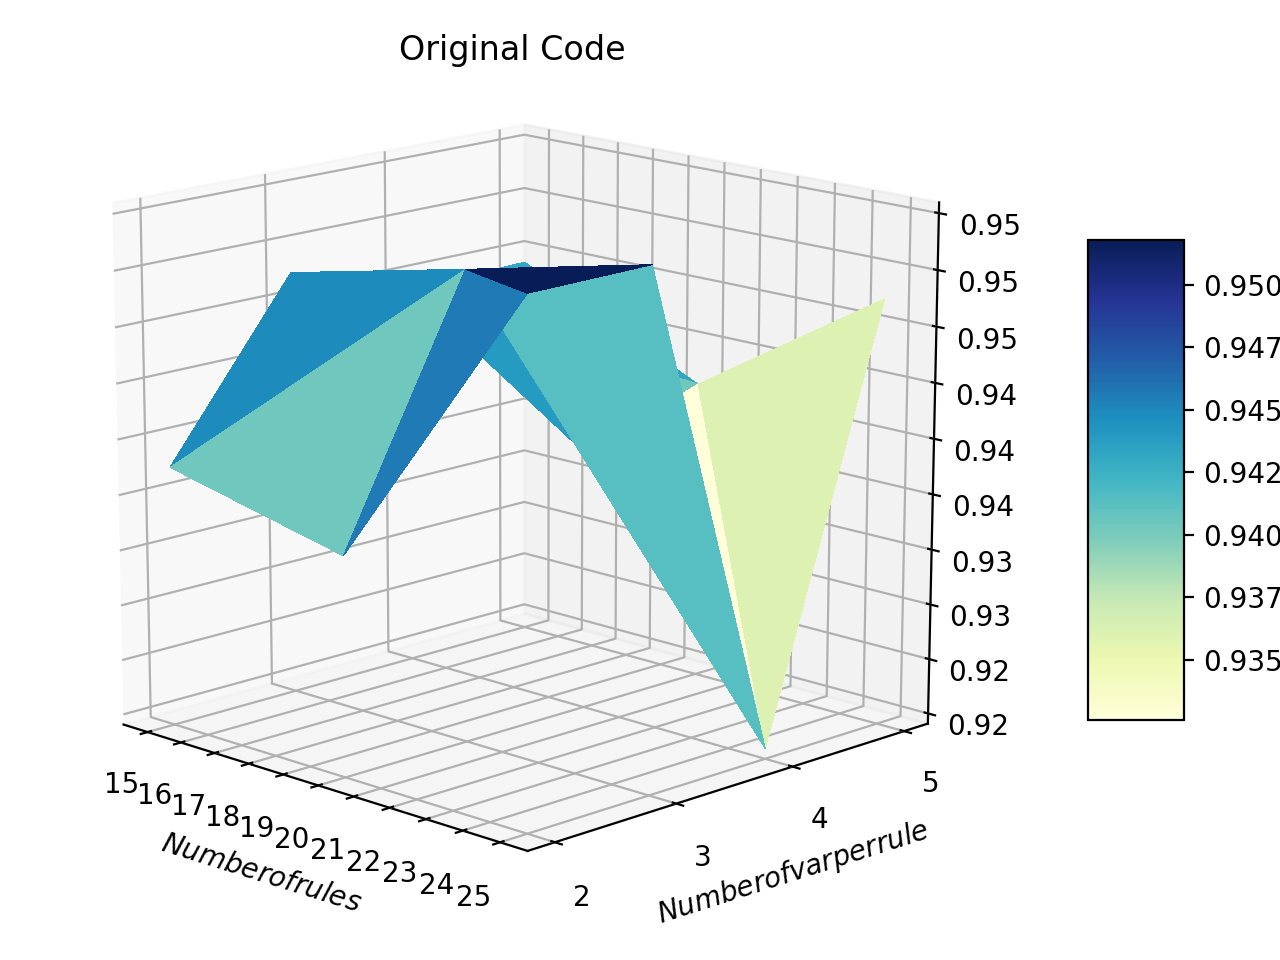

In [12]:
#plot 3D
%matplotlib notebook



X = data_frame_treated['N rule']
Y = data_frame_treated['N var per rule']
Z = data_frame_treated['acc']

y_axis_values = range(math.floor(min(Y)), math.ceil(max(Y))+1)
x_axis_values = range(math.floor(min(X)), math.ceil(max(X))+1)


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z,  cmap=cm.YlGnBu, linewidth=0, antialiased=False)

#ax.set_zlim(-1.01, 1.01)
ax.set_xticks(x_axis_values, minor=False)
ax.set_yticks(y_axis_values, minor=False)

ax.set_xlabel('$Number of rules$')
ax.set_ylabel('$Number of var per rule$')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))



fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('P1 Initial')
plt.show()

<b style="background-color:red;color:white">Question 5 (parts 0,1, and 2)</b> In your opinion, which values/ranges of both parameters: number of rules and vars per rule, should you choose to obtain the bests models? (comment briefly on the plot and include it into to report)


# Refine the parameter search

Now that we observed the plot we can refine the search for parameter values. As for the previous experiment it is necessary to:
<ul>
    <li>define new values/ranges for the number of rules </li>
    <li>define new values/ranges number of variable per rule </li>
    <li>change the path name where you want to save the new models </li>
    <li>change the name of the file that will contain the number of experiments</li>
     
</ul>

In [ ]:
#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience 
#('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [2,3]
var_per_rule_vec = [27,30]
#--------------------

#Change the path directory where you want to save the new results
#--------------------
model_train_obj.path_save_results = 'results_models_lab_2_p1_tuning/'
model_train_obj.path_save_results_values='values_lab0_p1_tuning.csv'
#--------------------




#--------------------
model_train_obj = ModelTrain(array_index_train_test = array_index_train_test_copy,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = 'results_models_lab_2_p1_tuning/',
                            path_save_results_values='values_lab0_p1_tuning.csv',
                             experience_name = 'second_exp')
#--------------------

for variation_a in rules_number_vec:
    for variation_b in var_per_rule_vec:
        model_train_obj.number_rule = variation_a
        model_train_obj.var_per_rule = variation_b
        model_train_obj.execute_cv()
 


save end
save end
save end
save end
save end
save end
save end
save end
save end
save end


<b style="background-color:red;color:white">Question 6 (part 0, 1, and 2)</b>: Explain your choice for the refined search of number of rules and variables per rule

In [ ]:
#read all csv
#--------------------
dataframe_results = pd.read_csv('values_lab0_p0.csv')
dataframe_results_b = pd.read_csv('values_lab0_p0_tuning.csv')
#--------------------

dataframe_results_c = dataframe_results_b.append(dataframe_results)

#dataframe_results_c = pd.read_csv('values_w.csv')
dataframe_results_c.columns = ['N rule', 'N var per rule','CV number', 'tn', 'fp', 'fn', 'tp', 'file_name']
dataframe_results_c.reset_index(drop=True)


# Model selection

Once we have tested all the configurations, we have obtained a (large) number of models exhibiting diverse performance metrics. The goal being to select the best models, a first selection is performed by applying a filter based on the diagnostic performance, thus reducing the number of models. Below you can see a scatter plot of all the models you obtained according to their sensitivity and specificity (as obtained on the validation subsets).

In [ ]:
%reload_ext autoreload

In [ ]:
%load_ext autoreload
%autoreload


#Plot all values
#don't forget to turn off the others plots
vec_values_sen_spe_models = libraries.interpretability_methods.getSenSpeValuesByScores(dataframe_results_c)
#vec_values_sen_spe_models = libraries.interpretability_methods.getSenSpeValuesByScores(data_frame_treated)

plt.scatter(vec_values_sen_spe_models['Sensitivity'],vec_values_sen_spe_models['Specificity'],s=10, marker='o')

plt.title('Threshold sen/spe')
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.savefig('ScatterPlot.png')

plt.xlim(0,1)
plt.ylim(0,1)

plt.show()


print('In total you have {0} models'.format(len(vec_values_sen_spe_models)))

## First selection filter: based on sen/spe

Having analysed the above performance overview of your models, you can apply a filter based on  sensitivity and specificity. In this way, only those models exhibiting better performance than some specified threshold will be selected for the next step.
The plot below shows the effect of the combined thresholds on the number of models remaining after the filter is applied.

In [ ]:
#that save x models
%matplotlib notebook

results_qty_models = libraries.interpretability_methods.plotSenSpeQtyModelsByThreshold(vec_values_sen_spe_models)


X = results_qty_models['sensitivity']
Y = results_qty_models['specificity']
Z = results_qty_models['qty_models']


max_quantity = results_qty_models.loc[results_qty_models['qty_models'].idxmax()]
max_quantity = int(max_quantity['qty_models'])

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z.values,  cmap=cm.YlGnBu, linewidth=0, antialiased=False)

ax.set_zticks(Z)

ax.set_xlabel('$Sensitivity$')
ax.set_ylabel('$Specificity$')



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))



fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Sen/Spe threshold')
plt.show()

On the base of this plot, you should decide on threshold values for both, specificity and sensitivity and apply them. The resulting subset of selected models is shown in the scatterplot below.

In [ ]:
%load_ext autoreload
%autoreload

#Put a limit in sen/spe
#Here you put the threshold for the sensitivity and specificity
#Don't forget to shave the plot and comment into your repport
#--------------------
value_sensitivity = 0.6
value_specificity = 0.6
#--------------------


#We apply them

vec_values_sen_spe_models_filtered = libraries.interpretability_methods.filterDataframeBySenSpeLimit(value_sensitivity, value_specificity, vec_values_sen_spe_models)
vec_values_sen_spe_models_filtered_invert = libraries.interpretability_methods.filterDataframeBySenSpeLimitContrary(value_sensitivity, value_specificity, vec_values_sen_spe_models)


figure = libraries.interpretability_plots.plotDataFrameValuesFiltered(value_sensitivity, value_specificity,vec_values_sen_spe_models_filtered, vec_values_sen_spe_models_filtered_invert)
print('In total you have {0} models'.format(len(vec_values_sen_spe_models_filtered)))


<b style="background-color:red;color:white">Question 7 (part 0, 1, and 2)</b>: Explain your choice of the threshold values for the sensitivity and specificity. (Save both plots into your repports)

## Second selection: frequency-based filter

Next, a second model-selection filter is applied based on the "importance" of the features. Such feature importance is represented in this context by their relative presence (i.e. their frequency) among the models. 

#### Frequency of the variables
The figure below shows the frequency of the variables among all the remaining models.

In [ ]:
#Don't forget to change the names of the files...


dataframe_first = pd.read_csv("values__lab0_p0.csv") 
dataframe_weight = pd.read_csv("values_lab0_p0_tuning.csv")


frames = [dataframe_first, dataframe_weight]
result = pd.concat(frames)

result = vec_values_sen_spe_models_filtered


<font color="red">Don't forget to put all your models in a single path... </font>

In [ ]:
%load_ext autoreload
%autoreload
  

list_models_path_complete = []
for index, row in vec_values_sen_spe_models_filtered.iterrows():
    model_path_complete = "results_models_lab_2_p0_all/" + str(row['file_name'])
    list_models_path_complete.append(model_path_complete)
    
#Perform the counting
list_models_vars = libraries.interpretability_methods.transformModelsToModelVarObj(list_models_path_complete)


In [ ]:
#plot histogram before cut

dict_values_resultant = libraries.interpretability_methods.countVarFreq(list_models_vars)


#indication of the number of models and variables
qty_models = len(list_models_vars)
qty_variables = len(dict_values_resultant)
print("You have {0} models and {1} variables".format(qty_models, qty_variables))

#Plot the new histogram
libraries.interpretability_plots.plotHistogramFreqVar(dict_values_resultant)

#### Choosing a frequency threshold
Filtering features by frequency will result in a reduction of both the number of features and the number of models, as models with eliminated variables are also eliminated. 

The plot below represents the number of models and variables that should remain after the filter is applied in function of the frequency threshold. It helps you to decide on which threshold to use for the filter.

(Note that the frequency of a feature is calculated as the number of <b>different models</b> where it appears irrespective of the number of rules containing it.)

In [ ]:
dict_values = libraries.interpretability_methods.countVarFreq(list_models_vars)


matrix_results = libraries.interpretability_methods.createPlotQtyVarPerModelByMinimumFreq(dict_values,list_models_vars)
display(matrix_results)


libraries.interpretability_plots.plotFreqVarPerFreqMinimum(matrix_results)

based on the plot above, select the minimum frequency (threshold) for the variables on your models.

<b style="background-color:red;color:white">Question 8 (part 0, 1, and 2)</b>: Explain your choice of the threshold. (Save both plots into your report)

You need to indicate the name of the file where you want to save the models

In [ ]:
#set the frequency value

#Create a copy of the list that contains the model_var objects
list_models_vars_cpopy = list_models_vars.copy()
#select the minimum frequency
#--------------------
nb_min_var = 3
#--------------------

#Perform the frequency
list_model_var_resultant = libraries.interpretability_methods.reduceQtyVars(nb_min_var, dict_values,list_models_vars_cpopy)
dict_values_resultant = libraries.interpretability_methods.countVarFreq(list_model_var_resultant)




#indication of the number of models and variables
qty_models = len(list_model_var_resultant)
qty_variables = len(dict_values_resultant)
print("You have now {0} models and {1} variables".format(qty_models, qty_variables))

#Plot the new histogram
libraries.interpretability_plots.plotHistogramFreqVar(dict_values_resultant)
#Show the frequency table
dict_Values_ordered = libraries.interpretability_methods.sort_reverse_dictionary_by_values(dict_values_resultant)
datafram_var_freq = pd.DataFrame(list(dict_Values_ordered.items()),columns=['Variable name','Frequence'])
display(datafram_var_freq)


#Perform the list of the models
#--------------------
file_name = 'models_selected.csv'
#--------------------
list_models_names=[model_var.model_path for model_var in list_model_var_resultant]
dataframe_names_files = pd.DataFrame(list_models_names)
dataframe_names_files.to_csv(file_name, sep=',', encoding='utf-8')

# Analysis of the selected models

Now that you have selected the best models, they are saved on the file "models_selected.CSV" (Or other file if you change the name...)
You may then load these models and use them to compute their predictions for the observations in the test set.

In [ ]:
%load_ext autoreload
%autoreload

# Import from file
#--------------------
fis = TrefleFIS.from_tff_file("results_models_lab_2_p0_all/second_exp_conf_A_CV_0_rule_4_var_per_rule_4.ftt")
#--------------------


# In the future, it could possible to call clf.predict_classes() directly
# see issue #1
y_pred_test = fis.predict(X_test)

results_list_predictions = np.squeeze(np.asarray(y_pred_test))


#libraries.results_plot.plotCMByTreflePredictions(y_test, results_list_predictions)
#Convert your results into binary values
results = []
for element in y_pred_test:
    if element > 0.5:
        results.append(1)
    else:
        results.append(0)

from libraries.ConfusionMatrix import ConfusionMatrix
cm = confusion_matrix(y_test, results)
n_classes = len(np.unique(y))
ConfusionMatrix.plot(cm, classes=range(n_classes), title="Confusion Matrix")

The code above is only an example of how to load models and test their performance in the test set. (Remember that the test set is the one who has not been used during the previous training/selectionn steps.)

<b><span style="background-color:red;color:white">Question 9 (parts 1 and 2)</span></b>: Among the final models, select three of them as follows: the smallest one (in terms of rules and variables), the best one (in terms of perfromance), and one in the "middle" that you consider as being a good trade off between size and performance. With them:
<ul>
    <li>Apply them to the test set and analyze the rfesults you obtained</li>
    <li>Analyze them in terms of size, rules, vars per rules and other characteristics that you think are relevant</li>
    <li>As far as possible, analyze their rules and try to "explain" their predictions.
</ul>
<br>

<b><span style="background-color:red;color:white">Question 10 (parts 1 and 2)</span></b>: Compare the features (variables) that were selected by Trefle (This algorithm, you know?) with those obtained in your previous laboratory on feature selection. Conclude.
<br>